Simulation "import"

In [ ]:
# @title
import numpy as np
from numpy import cos
from scipy.constants import pi


def scatter_pair(psi, n, m, *args, **kwargs):
    """Scatter the particles `n` and `m` given the state `psi`, and return the new state."""
    N = psi.ndim
    index = psi_index(N, n, m)

    psi = psi.copy()
    psi[index[0]], psi[index[1]], psi[index[2]], psi[index[3]] = scatter(psi[index[0]], psi[index[1]], psi[index[2]], psi[index[3]], *args, **kwargs)

    return psi


def psi_index(N, n, m):
    """Return indices for the 4 configurations of particles n and m."""
    index = np.full((4, N), slice(None))
    index[:, n] = [0, 0, 1, 1]
    index[:, m] = [0, 1, 0, 1]

    index = [tuple(i) for i in index]

    return index


def scatter(ee, eu, ue, uu, theta=pi/2, omega0_t=1):
    """Scatter two neutrinos given their combined state components, and return the new components."""
    phase = np.exp(-2j * omega0_t * (1 - cos(theta)))
    ee = ee * phase
    uu = uu * phase

    c = (eu + ue) / 2
    d = (eu - ue) / 2
    eu = c*phase + d
    ue = c*phase - d

    return ee, eu, ue, uu


def flavor_eigenstate(flavors):
    """Make a flavor eigenstate with the given flavors for each neutrino."""
    N = len(flavors)

    psi = np.zeros(N * [2], dtype=complex)
    psi[tuple(flavors)] = 1

    return psi


def random_scatter(psi0, n, *args, **kwargs):
    """Scatter random pairs of particles `n` times and return the states along the way."""
    N = psi0.ndim
    particle1 = np.random.randint(0, N, n)                      # Any random particle.
    particle2 = (particle1 + np.random.randint(1, N, n)) % N    # A random particle that's different from particle 1.

    psi = psi0
    yield psi

    for i, j in zip(particle1, particle2):
        psi = scatter_pair(psi, i, j, *args, **kwargs)
        yield psi


def density_matrix(psi, n):
    """The density matrix for the particle `n` from the multiparticle state `psi`."""
    N = psi.ndim

    psi_ = np.moveaxis(psi, n, 0)
    c_ab = psi_[:, np.newaxis]
    c_apb = psi_[np.newaxis, :]

    rho = (c_ab * c_apb.conj()).sum(axis=tuple(range(2, N + 1)))

    return rho


def entropy_rho(rho):
    """The Von-Neumann entropy of a density matrix."""
    import scipy
    return - np.trace(rho @ scipy.linalg.logm(rho))  # TODO


def entropy(psi, n):
    return entropy_rho(density_matrix(psi, n))


def flavor_expval(psi, n):
    """The expectation value of the flavor of neutrino `n`. Electron flavor = 0, muon flavor = 1."""
    return np.sum(np.abs(psi.take(1, n)) ** 2)


def average_entropy(psi):
    return np.mean([entropy(psi, n) for n in range(psi.ndim)])


def average_flavor(psi):
    return np.mean([flavor_expval(psi, n) for n in range(psi.ndim)])


Setup

In [ ]:
import matplotlib.pyplot as plt

plt.style.use('bmh')

def analyze(initial_flavors, n_scatters, verbose=False, *args, **kwargs):
  initial_flavors = np.array(initial_flavors)

  psi0 = flavor_eigenstate(initial_flavors)
  N = len(initial_flavors)

  entropies, flavors = [], []
  for i, psi in enumerate(random_scatter(psi0, n_scatters, *args, **kwargs)):
      if verbose:
          print(f"Scatter #{i}")

      entropies.append([entropy(psi, n) for n in range(N)])
      flavors.append([flavor_expval(psi, n) for n in range(N)])

  entropies, flavors = np.array(entropies).T, np.array(flavors).T

  avg_flavor = flavors.mean(axis=0)
  avg_entropy = entropies.mean(axis=0)

  sorted_flavors = [flavors[initial_flavors == 0], flavors[initial_flavors == 1]]
  sorted_avg_flavors = [flavors_.mean(axis=0) for flavors_ in sorted_flavors]

  return avg_flavor, sorted_avg_flavors, avg_entropy, sorted_flavors, entropies

def plot(avg_flavor, sorted_avg_flavors, avg_entropy, sorted_flavors, entropies, style=0):
  fig, ax = plt.subplots(figsize=(5, 3), dpi=150)

  alpha = 0.5
  for i, flavor in enumerate(sorted_flavors[0]):
    label = r"single particle flavors" if i == 0 else None
    ax.plot(flavor, c='red', alpha=alpha, label=label)
  for i, flavor in enumerate(sorted_flavors[1]):
    # label = r"$\nu_\mu$ flavors" if i == 0 else None
    ax.plot(flavor, c='red', alpha=alpha, label=None)
  for n, entropy_ in enumerate(entropies):
    label = "single particle entropies" if n == 0 else None
    ax.plot(entropy_, c='blue', alpha=alpha, label=label)

  if style == 1:
    ax.plot(avg_entropy, c='black', lw=2, label=r"average entropy")

  if style == 2:
    ax.plot(avg_entropy, c='black', lw=2, label=r"averages")
    ax.plot(sorted_avg_flavors[0], c='black', lw=2)
    ax.plot(sorted_avg_flavors[1], c='black', lw=2)
    ax.axhline(np.mean(avg_flavor), c='black', lw=2, zorder=-1)
  else:
    ax.axhline(np.mean(avg_flavor), c='black', lw=2, zorder=-1, label="average flavor")

  ax.axhline(np.log(2), c='black', ls=':', zorder=-1)

  ax.set_xlabel("number of interactions")
  ax.legend(fontsize=9)
  fig.tight_layout()



Plots

/usr/local/lib/python3.10/dist-packages/scipy/linalg/_matfuncs_inv_ssq.py:827: LogmExactlySingularWarning: The logm input matrix is exactly singular.
  warnings.warn(exact_singularity_msg, LogmExactlySingularWarning)
/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


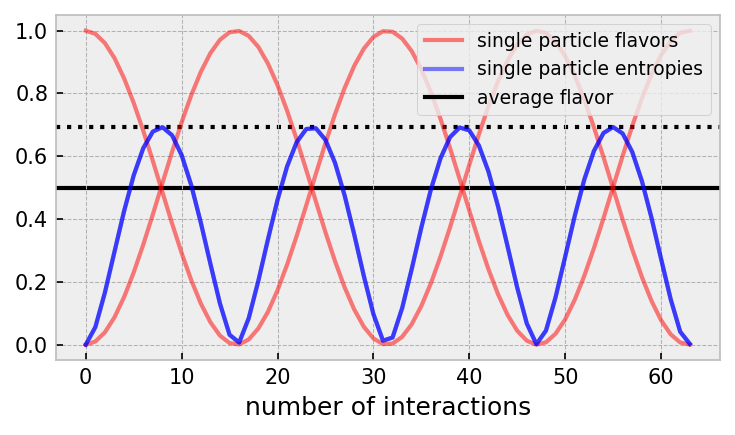

In [ ]:
psi0 = [1, 0]
omega0_t = 0.1
n_scatters = round(2 * pi/omega0_t)
data = analyze(psi0, n_scatters=n_scatters, omega0_t=omega0_t)

plot(*data)

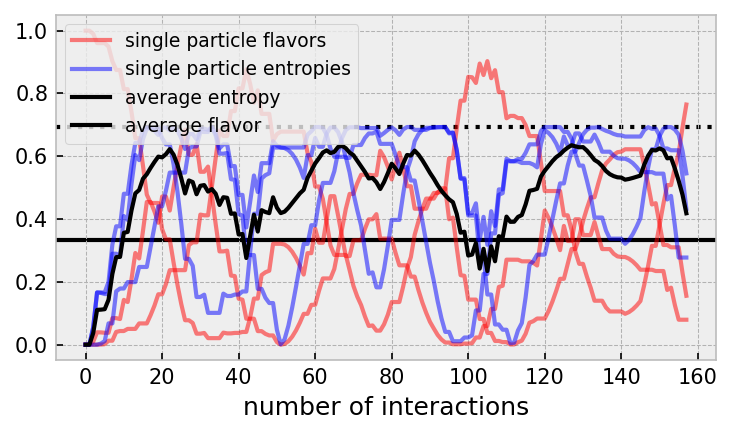

In [ ]:
psi0 = [1, 0, 0]
omega0_t = 0.1
n_scatters = round(5 * pi/omega0_t)
data = analyze(psi0, n_scatters=n_scatters, omega0_t=omega0_t)

plot(*data, style=1)

In [ ]:
psi0 = [1, 1, 0, 0]
omega0_t = 0.1
n_scatters = round(5 * pi/omega0_t)
data = analyze(psi0, n_scatters=n_scatters, omega0_t=omega0_t)

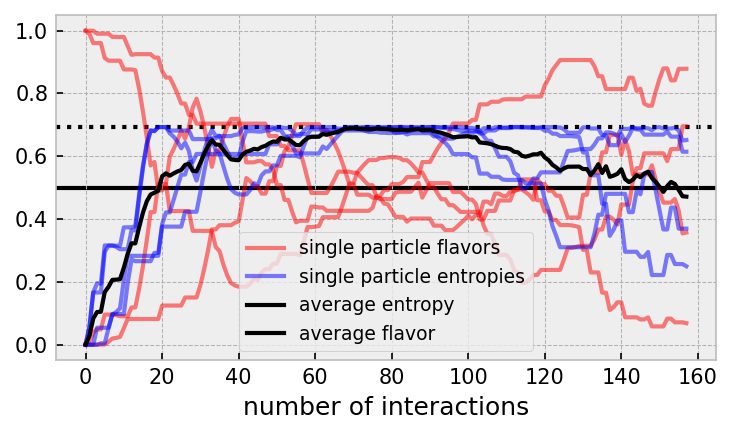

In [ ]:
plot(*data, style=1)

In [ ]:
psi0 = [1, 1, 1, 1, 0, 0, 0, 0]
omega0_t = 0.1
n_scatters = round(5 * pi/omega0_t)
data = analyze(psi0, n_scatters=n_scatters, omega0_t=omega0_t)

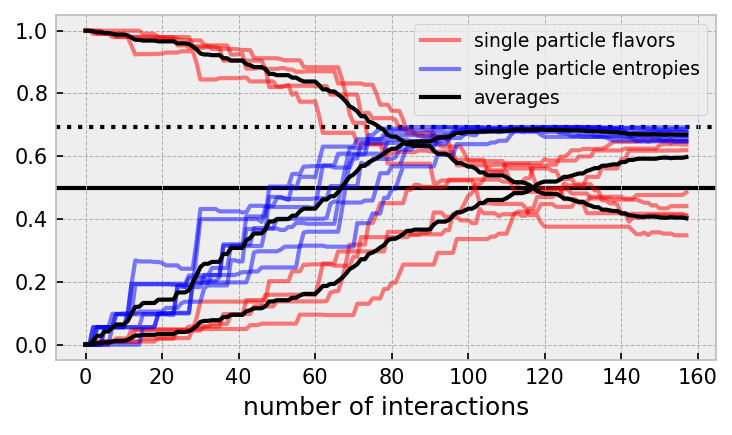

In [ ]:
plot(*data, style=2)

In [ ]:
psi0 = [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]
omega0_t = 0.1
n_scatters = round(20 * pi/omega0_t)
data = analyze(psi0, n_scatters=n_scatters, omega0_t=omega0_t)

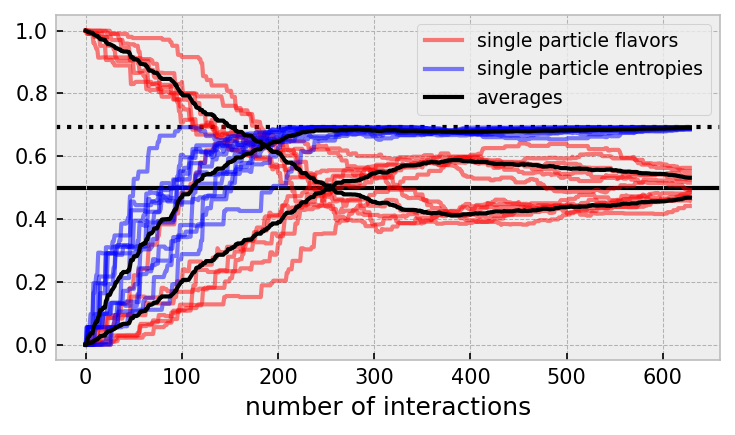

In [ ]:
plot(*data, style=2)

In [ ]:
psi0 = 10 * [0] + 10 * [1]
omega0_t = 0.1
n_scatters = round(20 * pi/omega0_t)
data = analyze(psi0, n_scatters=n_scatters, omega0_t=omega0_t)

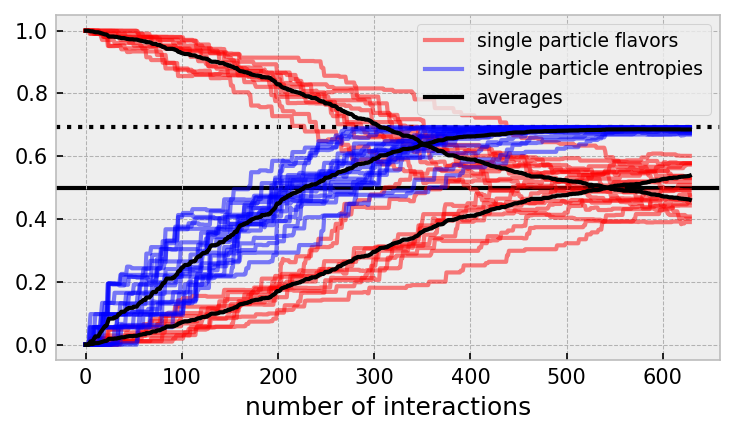

In [ ]:
plot(*data, style=2)